# 1) Librerías y configuración

In [63]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuraciones globales
IMG_SIZE = 224
DATA_DIR = "Dataset/"
CATEGORIES = os.listdir(DATA_DIR)

print(f"Categorías detectadas:\n")
for _ in CATEGORIES:
    print(_)

Categorías detectadas:

Anthracnose
Bacterial Blight
Citrus Canker
Curl Virus
Deficiency Leaf
Dry Leaf
Healthy Leaf
Sooty Mould
Spider Mites


# 2) Preprocesamiento con filtro Top-hat y Gaussiano

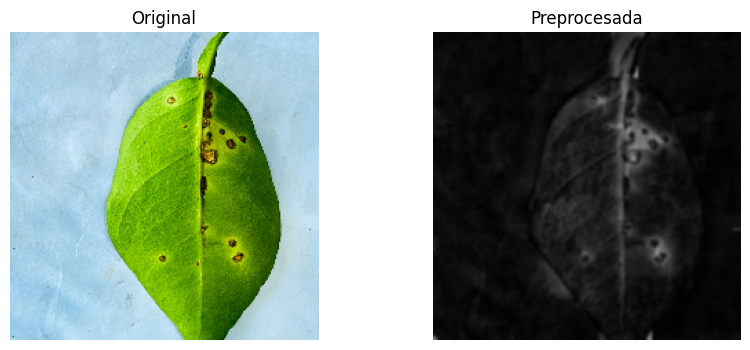

In [64]:
def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))
    tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
    blurred = cv2.GaussianBlur(tophat, (5,5), 0)
    final = cv2.merge([blurred, blurred, blurred])
    return final

# Prueba con una imagen aleatoria
sample_path = os.path.join(DATA_DIR, CATEGORIES[0], os.listdir(os.path.join(DATA_DIR, CATEGORIES[0]))[0])
img = cv2.imread(sample_path)
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img_preprocessed = preprocess_image(img_resized)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_preprocessed, cv2.COLOR_BGR2RGB), cmap='gray')
plt.title("Preprocesada")
plt.axis("off")
plt.show()


# 3) Cargar todas las imágenes y preprocesarlas

In [65]:
data = []
labels = []

for idx, category in enumerate(CATEGORIES):
    folder = os.path.join(DATA_DIR, category)
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        processed_img = preprocess_image(img)
        data.append(processed_img)
        labels.append(idx)

data = np.array(data) / 255.0
labels = to_categorical(labels)

print(f"Total de imágenes cargadas: {len(data)}")
print(f"Shape de las imágenes: {data[0].shape}")


Total de imágenes cargadas: 1354
Shape de las imágenes: (224, 224, 3)


# 4) Separar train/test y visualizar muestras

Tamaño del set de entrenamiento: (1083, 224, 224, 3)
Tamaño del set de prueba: (271, 224, 224, 3)


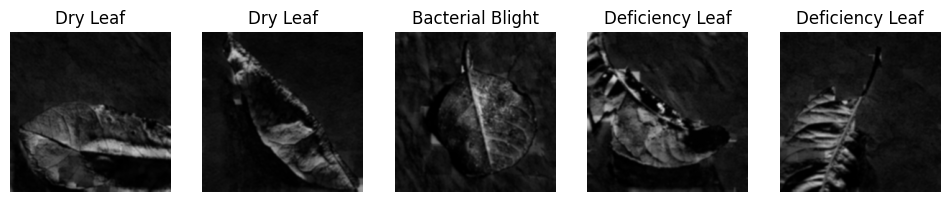

In [66]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(f"Tamaño del set de entrenamiento: {X_train.shape}")
print(f"Tamaño del set de prueba: {X_test.shape}")

# Visualización de muestras por clase
def plot_examples(X, y, n=5):
    plt.figure(figsize=(12, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(X[i])
        label = np.argmax(y[i])
        plt.title(CATEGORIES[label])
        plt.axis("off")
    plt.show()

plot_examples(X_train, y_train)


# 5) Aumento de datos con ImageDataGenerator

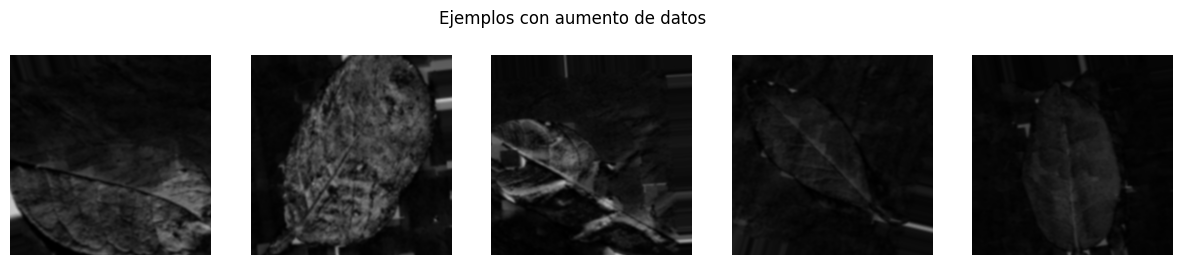

In [67]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# Mostrar algunas imágenes aumentadas
fig, axs = plt.subplots(1, 5, figsize=(15,3))
for X_batch, _ in datagen.flow(X_train, y_train, batch_size=5):
    for i in range(5):
        axs[i].imshow(X_batch[i])
        axs[i].axis("off")
    break
plt.suptitle("Ejemplos con aumento de datos")
plt.show()


# 6) Definir y compilar el modelo CNN

In [68]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(CATEGORIES), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\USUARIO\Desktop\Proyecto AML\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,908,553 (91.20 MB)

 Trainable params: 23,908,553 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

# 7) Entrenamiento del modelo

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=100)


c:\Users\USUARIO\Desktop\Proyecto AML\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 593ms/step - accuracy: 0.1759 - loss: 2.5592 - val_accuracy: 0.2989 - val_loss: 1.9215
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 539ms/step - accuracy: 0.3010 - loss: 1.9008 - val_accuracy: 0.3801 - val_loss: 1.7310
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 572ms/step - accuracy: 0.3294 - loss: 1.7918 - val_accuracy: 0.4502 - val_loss: 1.4913
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 559ms/step - accuracy: 0.4040 - loss: 1.6740 - val_accuracy: 0.4760 - val_loss: 1.3667
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 569ms/step - accuracy: 0.4486 - loss: 1.5788 - val_accuracy: 0.5129 - val_loss: 1.3479
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.4502 - loss: 1.5323 - val_accuracy: 0.5756 - val_loss: 1.1759
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 242ms/step - accuracy: 0.4387 - loss: 1.4784 - val_accuracy: 0.5572 - val_loss: 1.2196
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step - accuracy: 0.4758 - loss: 1.4380 - val

# 8) Evaluar y visualizar desempeño

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8019 - loss: 0.5725
Precisión en test: 78.97%


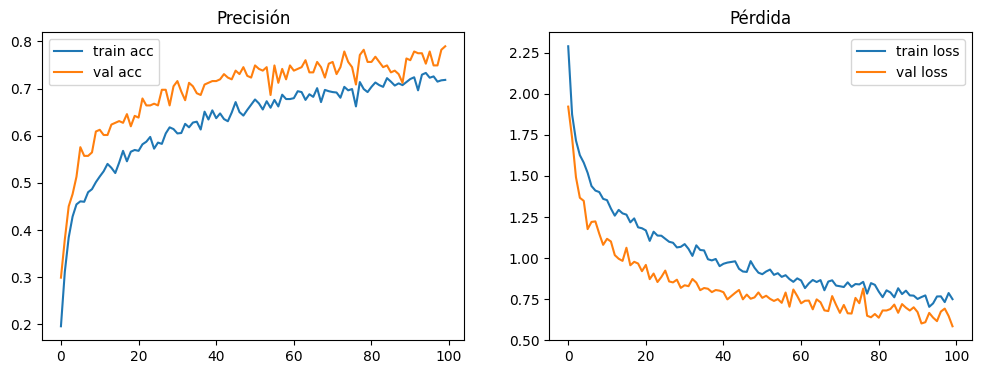

In [70]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Precisión en test: {acc * 100:.2f}%")

# Graficar curvas de pérdida y accuracy
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title("Precisión")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Pérdida")
plt.legend()

plt.show()


## 8.1) Matriz de confusión

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<Figure size 1000x800 with 0 Axes>

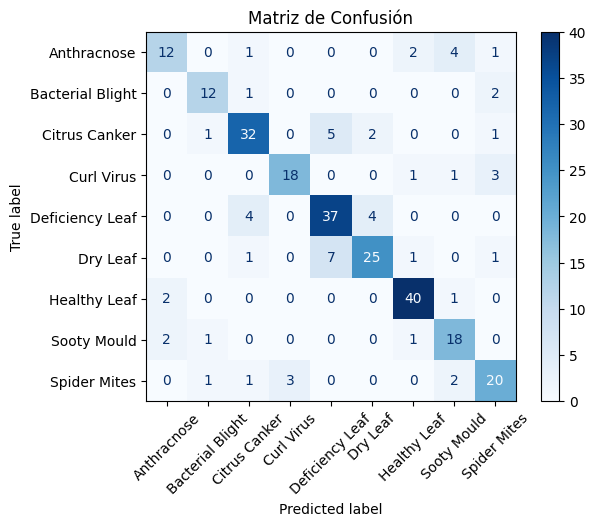

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Predicciones de clase
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de Confusión")
plt.show()


## 8.2) Clasificación por clase (precision, recall, f1-score)

In [81]:
from sklearn.metrics import classification_report

print("Reporte de Clasificación por clase:\n")
report = classification_report(y_true, y_pred, target_names=CATEGORIES)
print(report)


Reporte de Clasificación por clase:

                  precision    recall  f1-score   support

     Anthracnose       0.75      0.60      0.67        20
Bacterial Blight       0.80      0.80      0.80        15
   Citrus Canker       0.80      0.78      0.79        41
      Curl Virus       0.86      0.78      0.82        23
 Deficiency Leaf       0.76      0.82      0.79        45
        Dry Leaf       0.81      0.71      0.76        35
    Healthy Leaf       0.89      0.93      0.91        43
     Sooty Mould       0.69      0.82      0.75        22
    Spider Mites       0.71      0.74      0.73        27

        accuracy                           0.79       271
       macro avg       0.78      0.78      0.78       271
    weighted avg       0.79      0.79      0.79       271



# 8.3) Visualizar imágenes mal clasificadas

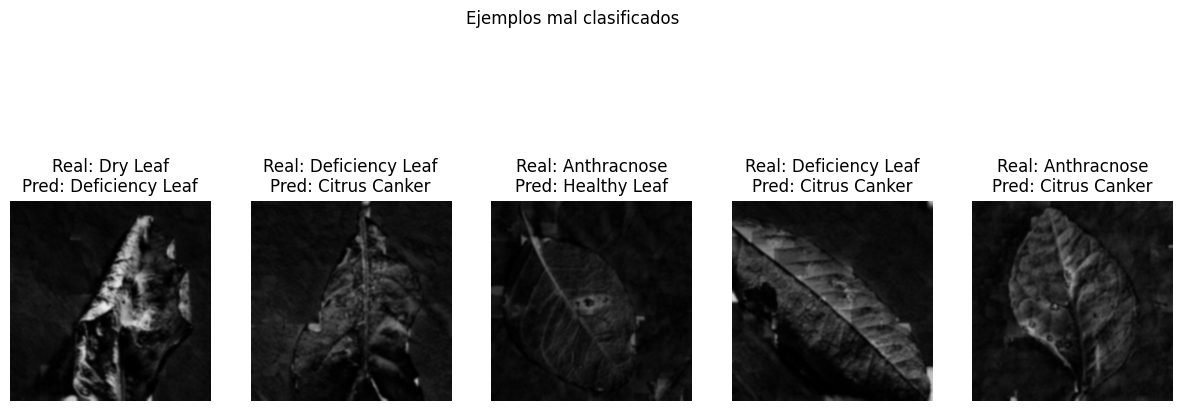

In [82]:
wrong_idx = np.where(y_pred != y_true)[0]

plt.figure(figsize=(15, 6))
for i, idx in enumerate(wrong_idx[:5]):  # mostrar solo 5 ejemplos
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[idx])
    plt.title(f"Real: {CATEGORIES[y_true[idx]]}\nPred: {CATEGORIES[y_pred[idx]]}")
    plt.axis("off")
plt.suptitle("Ejemplos mal clasificados")
plt.show()


# 8.4) Distribución de predicciones por clase

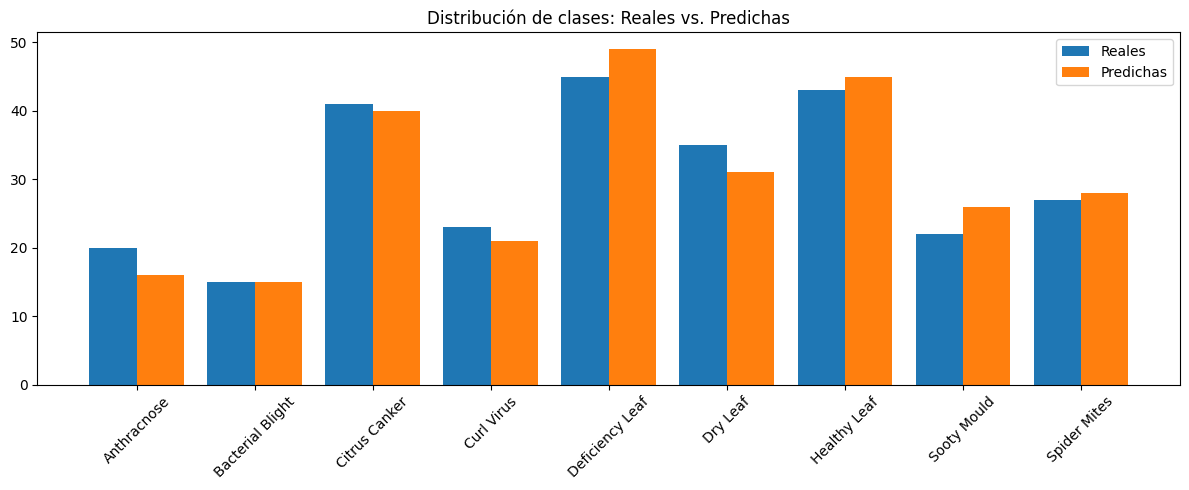

In [83]:
import pandas as pd

# Contar predicciones por clase
pred_counts = pd.Series(y_pred).value_counts().sort_index()
true_counts = pd.Series(y_true).value_counts().sort_index()

plt.figure(figsize=(12,5))
bar_width = 0.4
x = np.arange(len(CATEGORIES))

plt.bar(x - bar_width/2, true_counts, width=bar_width, label='Reales')
plt.bar(x + bar_width/2, pred_counts, width=bar_width, label='Predichas')
plt.xticks(ticks=x, labels=CATEGORIES, rotation=45)
plt.title("Distribución de clases: Reales vs. Predichas")
plt.legend()
plt.tight_layout()
plt.show()
